In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import matplotlib.pyplot as plt

from fuel.datasets.hdf5 import H5PYDataset

from scipy.stats import norm
from scipy.special import logsumexp
from IPython.display import display

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import mnist

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Variational Autoencoder Parameters

In [3]:
img_rows, img_cols, img_chns = 28, 28, 1

if K.image_data_format() == 'channels_first':
    original_img_size = (mg_chns, img_rows, imgi_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

batch_size = 100
latent_dim = 32
intermediate_dim = 128
epsilon_std = 1.0
epochs = 200
activation = 'relu'
dropout = 0.0
learning_rate = 0.001
decay = 0.0

## Load MNIST dataset

In [4]:
# Hugo Larochelle's Binarized MNIST
from mlio import *
def load_binarized_mnist(dir_path,load_to_memory=False):
    """
    Loads a binarized version of MNIST. 

    The data is given by a dictionary mapping from strings
    ``'train'``, ``'valid'`` and ``'test'`` to the associated pair of data and metadata.
    
    **Defined metadata:**

    * ``'input_size'``
    * ``'length'``

    """
    input_size=784
    dir_path = os.path.expanduser(dir_path)
    def load_line(line):
        tokens = line.split()
        return np.array([int(i) for i in tokens])

    train_file,valid_file,test_file = [os.path.join(dir_path, 'binarized_mnist_' + ds + '.amat') for ds in ['train','valid','test']]
    # Get data
    train,valid,test = [load_from_file(f,load_line) for f in [train_file,valid_file,test_file]]

    lengths = [50000,10000,10000]
    if load_to_memory:
        train,valid,test = [MemoryDataset(d,[(input_size,)],[np.float64],l) for d,l in zip([train,valid,test],lengths)]
        
    # Get metadata
    train_meta,valid_meta,test_meta = [{'input_size':input_size,
                              'length':l} for l in lengths]
    
    return {'train':(train,train_meta),'valid':(valid,valid_meta),'test':(test,test_meta)}

values = load_binarized_mnist('../../data/binarized_mnist', load_to_memory=True)

In [5]:
# Binarized MNIST
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train = np.round(X_train.reshape(X_train.shape[0], img_rows, img_cols, 1) / 255.)
# X_test = np.round(X_test.reshape(X_test.shape[0], img_rows, img_cols, 1) / 255.)

def reshape_data(data):
    return data.reshape(data.shape[0], img_rows, img_cols, 1)

X_train = reshape_data(values['train'][0].mem_data[0])
X_valid = reshape_data(values['valid'][0].mem_data[0])
X_test = reshape_data(values['test'][0].mem_data[0])

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


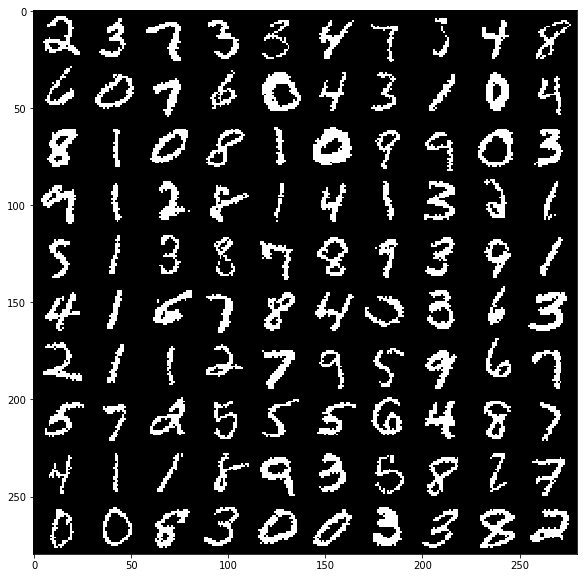

In [6]:
def display_digits(X, digit_size=28, n=10):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for i in range(n):
        for j in range(n):
            index = np.random.randint(0, X.shape[0])
            digit = X[index].reshape(digit_size, digit_size)
            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = digit
    
    plt.figure(figsize=(n, n))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    
display_digits(X_train)

# Helper Functions

In [7]:
def create_dense_layers(stage, width, activation=activation, dropout=True):
    dense_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Dense(width, name=dense_name),
        Activation(activation),
    ]
    if dropout:
        layers.append(Dropout(dropout))
    return layers

def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

def epsilon(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    return K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)

def combine_z_0(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    eps, z_mean, z_log_sigma = args
    return z_mean + K.exp(z_log_sigma) * eps

In [8]:
def create_enc_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Conv2D(name=conv_name, **kwargs),
        Activation(activation),
    ]
    return layers

def create_dense_layers(stage, width):
    dense_name = '_'.join(['enc_dense', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Dense(width, name=dense_name),
        BatchNormalization(name=bn_name),
        Activation(activation),
        Dropout(dropout),
    ]
    return layers

def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

def create_dec_trans_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['dec_trans_conv', str(stage)])
    bn_name = '_'.join(['dec_bn', str(stage)])
    layers = [
        Conv2DTranspose(name=conv_name, **kwargs),
        Activation(activation),
    ]
    return layers

## Loss Function

In [9]:
def logpz(x, x_decoded_mean):
    return -K.sum(0.5 * np.log(2*math.pi) + 0.5 * z ** 2, axis=-1)

def logqz_x(x, x_decoded_mean):
    return -K.sum(0.5 * np.log(2*math.pi) + 0.5 * e_0 ** 2 + z_log_sigma, axis=-1)

def logpx_z(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * img_chns * metrics.binary_crossentropy(x, x_decoded_mean)
    return -xent_loss

def vae_loss(x, x_decoded_mean):
    # ELBO: - [logp(x|z) + logp(z) - logq(z|x)] = -logp(x|z) - logp(z) + logq(z|x)
    return K.mean(-logpx_z(x, x_decoded_mean) - logpz(x, x_decoded_mean) + logqz_x(x, x_decoded_mean), axis=-1)

# Basic VAE

In [10]:
# Encoder
enc_filters=32
enc_layers = [
    create_enc_conv_layers(stage=1, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    create_enc_conv_layers(stage=2, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    create_enc_conv_layers(stage=3, filters=enc_filters, kernel_size=3, strides=2, padding='same'),
    Flatten(),
    create_dense_layers(stage=4, width=intermediate_dim),
    create_dense_layers(stage=5, width=intermediate_dim),
]
x_input = Input(shape=original_img_size)
_enc_dense = inst_layers(enc_layers, x_input)

# Original z_0
_z_mean_0 = Dense(latent_dim)(_enc_dense)
_z_log_sigma_0 = Dense(latent_dim)(_enc_dense)
encoder = Model(inputs=x_input, outputs=[_z_mean_0, _z_log_sigma_0])

# Decoder
dec_filters = 32
decoder_layers = [
    create_dense_layers(stage=10, width=intermediate_dim),
    create_dense_layers(stage=11, width=14 * 14 * 64),
    Reshape((14, 14, 64)),
    create_dec_trans_conv_layers(12, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    create_dec_trans_conv_layers(13, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    create_dec_trans_conv_layers(14, filters=dec_filters, kernel_size=3, strides=2, padding='same'),
    Conv2DTranspose(name='x_decoded', filters=1, kernel_size=1, strides=1, activation='sigmoid'),
]
z_input = Input(shape=(latent_dim,))
_dec_dense = inst_layers(decoder_layers, z_input)
decoder_output = _dec_dense
decoder = Model(inputs=z_input, outputs=decoder_output)

In [11]:
g_input = Input(shape=original_img_size)
z_mean, z_log_sigma = encoder(g_input)
e_0 = Lambda(epsilon)(z_mean)
z = Lambda(combine_z_0, output_shape=(latent_dim,))([e_0, z_mean, z_log_sigma])
g_output = decoder(z)

vae = Model(inputs=g_input, outputs=g_output)
optimizer = Adam(lr=learning_rate, decay=decay)
vae.compile(optimizer=optimizer, loss=vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 32), (None,  847552      input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (100, 32)            0           model_1[1][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (100, 32)            0           lambda_1[0][0]                   
                                                                 model_1[1][0]                    
          

In [12]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=0.1, patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.01 * learning_rate)
tensorboard = keras.callbacks.TensorBoard(histogram_freq=10, batch_size=32, write_graph=True, write_grads=True)

callbacks=[early_stopping, reduce_lr]
if 'CMDLINE' not in os.environ:
    callbacks += [TQDMNotebookCallback()]

history = vae.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_valid, X_valid),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  495.19625091552734


,val_loss,loss,lr
count,50.000000,50.000000,50.000000
mean,95.815798,95.286105,0.000579
std,5.314803,9.749079,0.000386
min,92.543482,89.174324,0.000063
0%,92.543482,89.174324,0.000063
25%,92.860526,90.309928,0.000250
50%,93.505264,92.324394,0.000500
75%,96.832847,96.710079,0.001000
95%,103.606324,106.575243,0.001000
99%,116.886833,133.777679,0.001000


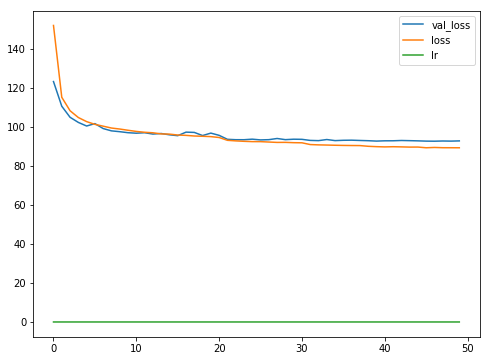

In [13]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

In [14]:
# Eval logpx loss
eval_result = vae.evaluate(x=X_test, y=X_test, batch_size=batch_size)

print("VLB = %.2f" % -eval_result)

10000/10000 [==============================] - 1s 63us/step
VLB = 92.33


In [15]:
def compute_samples(data, num_samples, debug=False):
    """ Sample from importance distribution z_samples ~ q(z|X) and
        compute p(z_samples), q(z_samples) for importance sampling
    """
    z_mean, z_log_sigma = encoder.predict(data)
    z_samples = []
    qz = []
    
    for m, s in zip(z_mean, z_log_sigma):
        z_vals = [np.random.normal(m[i], np.exp(s[i]), num_samples)
                  for i in range(len(m))]
        qz_vals = [norm.pdf(z_vals[i], loc=m[i], scale=np.exp(s[i]))
                  for i in range(len(m))]
        z_samples.append(z_vals)
        qz.append(qz_vals)
    
    z_samples = np.array(z_samples)
    pz = norm.pdf(z_samples)
    qz = np.array(qz)
    
    z_samples = np.swapaxes(z_samples, 1, 2)
    pz = np.swapaxes(pz, 1, 2)
    qz = np.swapaxes(qz, 1, 2)
   
    if debug:
        print(z_mean.shape, z_log_sigma.shape)
        print('m, s', m[0], s[0])
        print('samples', z_samples[-1][0])
        print('pvals', pz[-1][0])
        print('qvals', qz[-1][0])
        
        print(z_samples.shape)
        print(pz.shape)
        print(qz.shape)
    
    return z_samples, pz, qz
    
#compute_samples(X_test[:10], 4, debug=True);

In [16]:
def estimate_logpx_batch(data, num_samples, debug=False):
    z_samples, pz, qz = compute_samples(data, num_samples)
    assert len(z_samples) == len(data)
    assert len(z_samples) == len(pz)
    assert len(z_samples) == len(qz)
    
    # Calculate importance sample
    # \log p(x) = E_p[p(x|z)]
    # = \log(\int p(x|z) p(z) dz)
    # = \log(\int p(x|z) p(z) / q(z|x) q(z|x) dz)
    # = E_q[p(x|z) p(z) / q(z|x)]
    # ~= \log(1/n * \sum_i p(x|z_i) p(z_i)/q(z_i))
    # = \log p(x) = \log(1/n * \sum_i e^{\log p(x|z_i) + \log p(z_i) - \log q(z_i)})
    # = \log p(x) = -\logn + \logsumexp_i(\log p(x|z_i) + \log p(z_i) - \log q(z_i))
    # See: scipy.special.logsumexp
    result = []
    for i in range(len(data)):
        datum = data[i].reshape(784)
        x_predict = decoder.predict(z_samples[i]).reshape(-1, 784)
        x_predict = np.clip(x_predict, np.finfo(float).eps, 1. - np.finfo(float).eps)
        p_vals = pz[i]
        q_vals = qz[i]

        # \log p(x|z) = Binary cross entropy
        logp_xz = np.sum(datum * np.log(x_predict) + (1. - datum) * np.log(1.0 - x_predict), axis=-1)
        logpz = np.sum(np.log(p_vals), axis=-1)
        logqz = np.sum(np.log(q_vals), axis=-1)
        argsum = logp_xz + logpz - logqz
        logpx = -np.log(num_samples) + logsumexp(argsum)
        result.append(logpx)
        
        if debug:
            print(x_predict.shape)
            print(p_vals.shape)
            print(q_vals.shape)
            print(logp_xz.shape)
            print(logpz.shape)
            print(logqz.shape)
            print("logp_xz", logp_xz)
            print("logpz", logpz)
            print("logqz", logqz)
            print(argsum.shape)
            print("logpx", logpx)
            
    return np.array(result)
            
#estimate_logpx_batch(X_test[:2], num_samples=128, debug=True)
#pass

In [17]:
def estimate_logpx(data, num_samples, verbosity=0):
    batches = []
    iterations = int(np.ceil(1. * len(data) / batch_size))
    for b in range(iterations):
        batch_data = data[b * batch_size:(b+1) * batch_size]
        batches.append(estimate_logpx_batch(batch_data, num_samples))
        if verbosity and b % max(11 - verbosity, 1) == 0:
            print("Batch %d [%d, %d): %.2f" % (b, b*batch_size, (b+1) * batch_size, 
                                               np.mean(np.concatenate(batches))))
            np.mean(np.concatenate(batches))        
    return np.mean(np.concatenate(batches))
    
logpx = estimate_logpx(X_test, num_samples=128, verbosity=1)
print("log p(x) = %.2f" % logpx)

Batch 0 [0, 100): -96.87
Batch 10 [1000, 1100): -92.99
Batch 20 [2000, 2100): -71.16
Batch 30 [3000, 3100): -80.12
Batch 40 [4000, 4100): -84.05
Batch 50 [5000, 5100): -84.68
Batch 60 [6000, 6100): -86.49
Batch 70 [7000, 7100): -86.81
Batch 80 [8000, 8100): -85.78
Batch 90 [9000, 9100): -87.46
log p(x) = -87.08


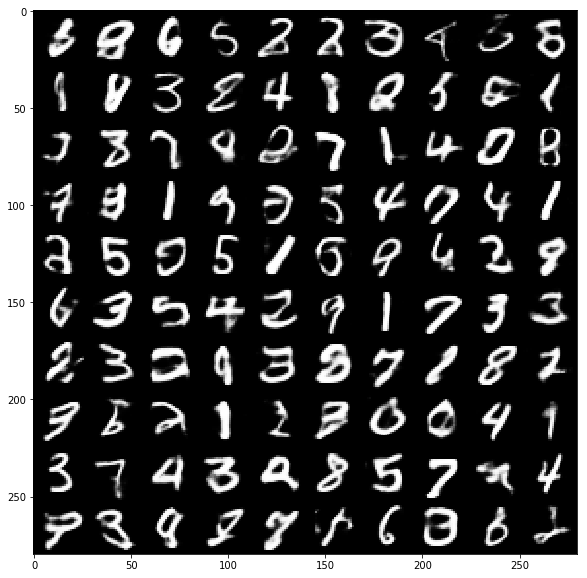

In [18]:
import matplotlib.pyplot as plt
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for j in range(n):
    z_sample = np.random.normal(size=latent_dim * batch_size).reshape(batch_size, latent_dim)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded.reshape(batch_size, digit_size, digit_size, img_chns)
    for i in range(n):
        d_x = i * digit_size
        d_y = j * digit_size
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit[i, :, :, 0]
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()